# Imports

In [1]:
import pathlib

import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import seaborn as sns
import trackpy as tp
from matplotlib.ticker import FormatStrFormatter
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy.ndimage import rotate, shift
from scipy.stats import mode
from tqdm.notebook import tqdm

from data import MicroscopyData
from track import particleTracker
from utils import save_fig

# Load data

In [2]:
data_path = "../data/220930"
data_name = "220930_1um-beads.nd2"
dataset = MicroscopyData(data_path, data_name)
output_path = pathlib.Path(
    "../figures/%s" % (dataset.data_name[: dataset.data_name.rfind(".")])
)
output_path.mkdir(parents=True, exist_ok=True)

mtoc_ch, track_ch = 1, 0
tracker = particleTracker(dataset, True)
centrosome_df = pd.read_hdf(dataset.full_mtoc_path, key="mtoc")
n_mtoc = len(centrosome_df.columns) // 2

/home/liboyan/miniconda3/envs/mt/lib/python3.9/site-packages/pims/base_frames.py:478: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


# Calculate global drift

Compare the trajectory of MToC with the global drift. The two trajectories should be similar, or there might be twisting of asters which suggests a bad quality of data.

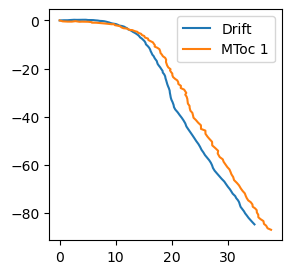

In [3]:
traj_df = tracker.traj_df.copy()
drift_df = tp.compute_drift(traj_df)
drift_df.columns = [col + "_drift" for col in drift_df.columns]
drift_df.loc[0, "x_drift"] = 0
drift_df.loc[0, "y_drift"] = 0
drift_df = drift_df.sort_index()
_, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(drift_df.y_drift, drift_df.x_drift, label="Drift")
for cen in range(n_mtoc):
    ax.plot(
        centrosome_df["centrosome_%d_y" % cen]
        - centrosome_df.loc[0, "centrosome_%d_y" % cen],
        centrosome_df["centrosome_%d_x" % cen]
        - centrosome_df.loc[0, "centrosome_%d_x" % cen],
        label="MToc %d" % (cen + 1),
    )
ax.legend()

# Locations of MToC

In [4]:
# If you think the MToC trajectory is good enough, you can set centrosome_robust to True; otherwise, set it to False.
centrosome_robust = True
substract_drift = True
if not centrosome_robust:
    centrosome_df = pd.DataFrame(
        columns=list(centrosome_df.columns),
        data=np.array([centrosome_df.values[0, :].tolist()] * len(dataset.frames)),
    )
    if substract_drift:
        for cen in range(n_mtoc):
            centrosome_df["centrosome_%d_x" % cen] = (
                centrosome_df.loc[0, "centrosome_%d_x" % cen] + drift_df.x_drift
            )
            centrosome_df["centrosome_%d_y" % cen] = (
                centrosome_df.loc[0, "centrosome_%d_y" % cen] + drift_df.y_drift
            )
else:
    if n_mtoc == 1:
        drift_df.y_drift = (
            centrosome_df["centrosome_%d_y" % cen]
            - centrosome_df.loc[0, "centrosome_%d_y" % cen]
        )
        drift_df.x_drift = (
            centrosome_df["centrosome_%d_x" % cen]
            - centrosome_df.loc[0, "centrosome_%d_x" % cen]
        )

# Display MToC and trajetories

In [5]:
centrosome_df["frame"] = np.arange(len(centrosome_df), dtype=int)
viewer = tracker.visualize_traj(track_ch, run=False)
dataset.frames.iter_axes = "c"
dataset.frames.bundle_axes = "tyx"
for i in range(n_mtoc):
    points = centrosome_df[
        ["frame", "centrosome_%d_y" % i, "centrosome_%d_x" % i]
    ].values
    viewer.add_points(points, name="MToC-%d" % i, face_color="white", size=30)
dataset.reset_axes()
centrosome_df.drop(["frame"], axis=1, inplace=True)

# Merge with timepoints and centrosome locations

In [6]:
traj_df = tracker.traj_df.copy()
traj_df["t"] = traj_df.frame.map(dataset.timpoints)
merge_col = [col for col in centrosome_df.columns if col != "frame"]
traj_df = traj_df.merge(centrosome_df[merge_col], left_index=True, right_index=True)
traj_df = traj_df.merge(drift_df, left_index=True, right_index=True)

distance_cols = (
    ["y", "x", "x_drift", "y_drift"]
    + [f"centrosome_{i}_x" for i in range(n_mtoc)]
    + [f"centrosome_{i}_y" for i in range(n_mtoc)]
)
for col in distance_cols:
    traj_df[col] = traj_df[col].apply(lambda x: x * dataset.mpp)
traj_df.head(3)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,t,centrosome_0_y,centrosome_0_x,y_drift,x_drift
0,464.657208,107.878815,127240.517906,1.474276,0.067737,14452.375619,389218.0,0.007754,0,1,1.217144,348.014757,330.810953,0.0,0.0
0,464.294879,515.123104,116190.817811,1.524566,0.245206,12948.935676,359517.0,0.008412,0,2,1.217144,348.014757,330.810953,0.0,0.0
0,464.188881,346.505951,64223.920237,1.828228,0.227042,5061.710803,558682.0,0.005362,0,3,1.217144,348.014757,330.810953,0.0,0.0


# Calculate features in beads trajectories

For each bead, calculate:
- which MToC it belongs to
- net replacement, maximal replacement
- instantaneous radial velocity, active radial velocity, maximal radial velocity
- instantaneous angular velocity, active angular velocity, maximal angular velocity

In [8]:
# Calculate distances to MToC
for i in range(n_mtoc):
    traj_df["distance_to_centrosome_%d" % i] = np.sqrt(
        (traj_df.y - traj_df["centrosome_%d_y" % i]) ** 2
        + (traj_df.x - traj_df["centrosome_%d_x" % i]) ** 2
    )

particle_df_group = []
beads_features = []
walking_thresh = 0.04
w_thresh = 1
along_thresh = 0.1

for particle in tqdm(traj_df.particle.unique()):
    particle_df = traj_df[traj_df.particle == particle].copy()
    conv_size = int(25 / np.diff(particle_df.t).mean())
    segment_minsize = int(5 / np.diff(particle_df.t).mean())

    # which centrosome the bead belongs to
    if n_mtoc > 1:
        distances = particle_df[
            ["distance_to_centrosome_%d" % i for i in range(n_mtoc)]
        ].values
        centrosome = mode(np.argmin(distances, axis=1), keepdims=True).mode[0]
    else:
        centrosome = 0
    particle_df["centrosome"] = centrosome

    # Radial replacement
    d = particle_df["distance_to_centrosome_%d" % centrosome].values
    x_centrosome = particle_df["centrosome_%d_x" % centrosome].values
    y_centrosome = particle_df["centrosome_%d_y" % centrosome].values

    # Radial velocity
    dd = np.diff(d)
    t = particle_df.t.values
    dt = np.diff(t)
    v = -dd / dt
    particle_df["v"] = [np.nan] + v.tolist()

    # Angular velocity
    x = particle_df.x.values
    y = particle_df.y.values
    # Law of cosine
    da = d[1:] ** 2 + d[:-1] ** 2 - (x[1:] - x[:-1]) ** 2 - (y[1:] - y[:-1]) ** 2
    da /= 2 * d[1:] * d[:-1]
    da[da > 1] = 1
    da = np.arccos(da)
    w = (da / dt) / np.pi * 180
    particle_df["w"] = [np.nan] + w.tolist()


    # Walk or stop
    v_conv = np.convolve(v, np.ones(conv_size), "same") / conv_size
    mov_seq = ((v > walking_thresh) & (w < w_thresh)).astype(int)
    v_seg = []
    v_seg_mov = []
    run_start = np.where((mov_seq[:-1] == 0) & (mov_seq[1:] == 1))[0] + 1
    run_end = np.where((mov_seq[:-1] == 1) & (mov_seq[1:] == 0))[0]
    walking_arr = []
    walking_time = []
    if len(run_start) > 0 and len(run_end) > 0:
        if run_start[0] > run_end[0]:
            run_start = [0] + run_start.tolist()
        e_last = -10
        s_new = []
        e_new = []
        for i in range(min(len(run_start), len(run_end))):
            s = run_start[i]
            e = run_end[i]
            if s - e_last <= segment_minsize and s != 0:
                e_new = e_new[:-1]
                e_new.append(e)
            elif e - s <= segment_minsize:
                continue
            else:
                s_new.append(run_start[i])
                e_new.append(run_end[i])
            e_last = e
        s_new = np.array(s_new)
        e_new = np.array(e_new)
        mov_seq = np.array([False] * len(mov_seq))
        e_last = 0
        for s, e in zip(s_new, e_new):
            mov_seq[s:e+1] = True
            v_seg_mov.append(v[s:e+1].mean())
            v_seg.append(v[s:e+1].mean())
            if s > 1:
                v_seg.append(v[e_last+1:s].mean())
            e_last = e
        
        if len(s_new) > 0:
            walking_arr = d[s_new] - d[e_new]
            walking_time = -t[s_new] + t[e_new]
            
    active = (
        (d[0] - d[-1] > 5)
        & (d.min() < 150)
        & (mov_seq.sum() > along_thresh * len(mov_seq))
    )

    new_dict = {
        "particle": particle,
        "centrosome": centrosome,
        "d_net": d[0] - d[-1],
        "d_max": d.max() - d.min(),
        "active": active,
        "v_act": v[mov_seq].mean() if np.any(mov_seq) else 0,
        "v_act_max": np.sort(v[mov_seq])[-5:].mean() if np.any(mov_seq) else 0,
        "v_max": np.sort(v)[-5:].mean(),
        "v_conv_max": np.sort(v_conv)[-5:].mean(),
        "v_mean": v.mean(),
        "w_max": np.sort(w)[-5:].mean(),
        "d_walk": walking_arr,
        "d_walk_max": np.max(walking_arr) if len(walking_arr) > 0 else 0,
        "t_walk": walking_time,
        "t_walk_max": np.max(walking_time) if len(walking_time) > 0 else 0,
        "v_seg": v_seg,
        "v_seg_mov": v_seg_mov,
    }
    beads_features.append(new_dict)
    particle_df_group.append(particle_df)

traj_df_2 = pd.concat(particle_df_group, ignore_index=True)
beads_df = pd.DataFrame.from_records(beads_features)
active_map = beads_df[["particle", "active"]].set_index("particle").to_dict()["active"]
traj_df_2["active"] = traj_df_2.particle.map(active_map)

# 
traj_df_3 = traj_df_2.copy()
traj_df_3[distance_cols] = traj_df_3[distance_cols] / dataset.mpp
traj_df_3.y = traj_df_3.y - traj_df_3.y_drift
traj_df_3.x = traj_df_3.x - traj_df_3.x_drift
traj_df_3.head()

  0%|          | 0/1816 [00:00<?, ?it/s]

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,t,centrosome_0_y,centrosome_0_x,y_drift,x_drift,distance_to_centrosome_0,centrosome,v,w,active
0,1430.895156,332.208931,127240.517906,1.474276,0.067737,14452.375619,389218.0,0.007754,0,1,1.217144,1071.698925,1018.720430,0.000000,0.000000,251.603258,0,NaN,NaN,False
1,1431.371306,332.155711,126108.004772,1.457405,0.081697,14648.014047,390504.0,0.007709,1,1,6.010143,1072.241379,1018.344828,0.542455,-0.375603,251.690286,0,-0.018157,0.016540,False
2,1430.933657,331.697762,128938.829285,1.526990,0.066487,13869.691367,392946.0,0.007738,2,1,10.994030,1073.157534,1018.232877,1.458610,-0.487553,251.756140,0,-0.013213,0.010618,False
3,1431.004015,331.634924,130525.650376,1.457166,0.099476,15177.729783,392683.0,0.007818,3,1,15.986671,1073.875000,1018.229167,2.176075,-0.491263,251.784810,0,-0.005742,0.011629,False
4,1429.483951,331.383187,131188.470936,1.463345,0.112214,15186.444706,393558.0,0.007712,4,1,20.994174,1074.520833,1018.423611,2.821909,-0.296819,251.628957,0,0.031124,0.010819,False


# Shift frames

In [9]:
dataset = MicroscopyData(data_path, data_name)
mtoc_locs = drift_df.values

dataset.frames = [
    shift(dataset.frames[i][track_ch, :, :], -mtoc_locs[i])
    for i in tqdm(range(len(mtoc_locs)))
]
if centrosome_robust and n_mtoc == 1:
    traj = list(
        zip(
            traj_df_3.particle,
            traj_df_3.frame,
            traj_df_3.y.values,
            traj_df_3.x.values,
        )
    )
else:
    traj = list(
        zip(
            traj_df_3.particle,
            traj_df_3.frame,
            traj_df_3.y.values - traj_df_3.y_drift,
            traj_df_3.x.values - traj_df_3.x_drift,
        )
    )

/home/liboyan/miniconda3/envs/mt/lib/python3.9/site-packages/pims/base_frames.py:478: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


  0%|          | 0/121 [00:00<?, ?it/s]

# Show aligned video

In [10]:
viewer = napari.view_image(np.array(dataset.frames))
viewer.add_tracks(traj, name="tracks")
for i in range(n_mtoc):
    points = np.repeat(
        centrosome_df[["centrosome_%d_y" % i, "centrosome_%d_x" % i]]
        .values[0]
        .reshape((1, 2)),
        len(centrosome_df),
        axis=0,
    )
    points = np.concatenate(
        [np.arange(len(centrosome_df)).reshape((-1, 1)), points], axis=1
    )
    viewer.add_points(points, name="MToC-%d" % i, face_color="red", size=30)

# Display all trajectories

Saving figure ../figures/220930_1um-beads/Active_trajectories


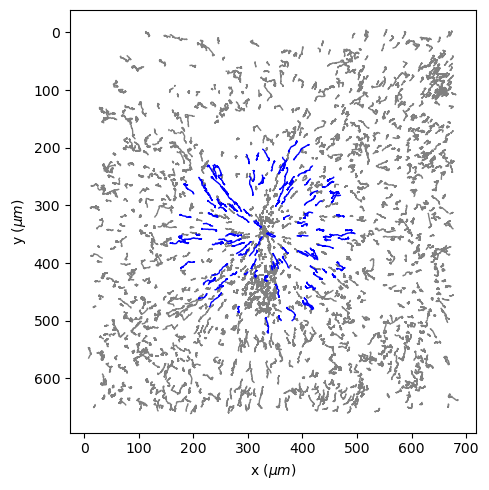

In [11]:
traj_df_3[distance_cols] = traj_df_3[distance_cols] * dataset.mpp
_, ax = plt.subplots(1, 1, figsize=(5, 5))
tp.plot_traj(
    traj_df_3[np.logical_not(traj_df_3.active)],
    plot_style={"linewidth": 1, "color": "gray"},
    ax=ax,
)
for i in range(n_mtoc):
    tp.plot_traj(
        traj_df_3[(traj_df_3.active) & (traj_df_3.centrosome == i)],
        plot_style={
            "linewidth": 1,
            "color": ["blue", "orange", "red", "black", "brown"][i],
        },
        ax=ax,
    )
ax.set_xlabel(r"x ($\mu m$)")
ax.set_ylabel(r"y ($\mu m$)")
save_fig(output_path / "Active_trajectories")

# Isolated single-bead trajectory

## Trajectory location

In [12]:
beads_df[(beads_df.d_net > 50) & (beads_df.active)].head(5)

,particle,centrosome,d_net,d_max,active,v_act,v_act_max,v_max,v_conv_max,v_mean,w_max,d_walk,d_walk_max,t_walk,t_walk_max,v_seg,v_seg_mov
713,843,0,57.714227,58.877651,True,0.16639,0.446963,0.446963,0.331332,0.096127,0.146558,"[11.243291917712426, 18.052751517173505, 7.972...",18.052752,"[39.97807137498259, 85.00003187501432, 54.9907...",85.000032,"[0.2572583524571511, -0.03764365354806461, 0.2...","[0.2572583524571511, 0.20703859157671, 0.14612..."


Saving figure ../figures/220930_1um-beads/single_trajectory


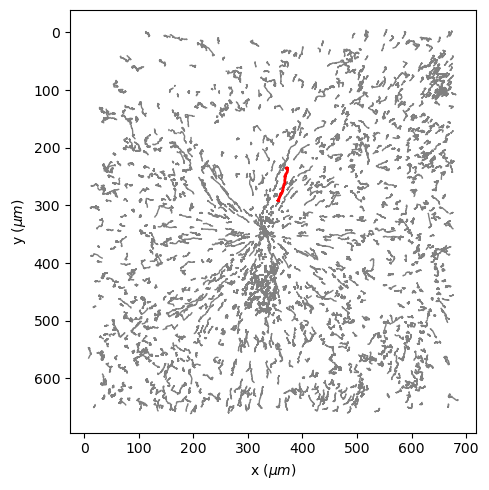

In [13]:
particle = 843
_, ax = plt.subplots(1, 1, figsize=(5, 5))
tp.plot_traj(
    traj_df_3[traj_df_3.particle != particle],
    plot_style={"linewidth": 1, "color": "gray"},
    ax=ax,
)

tp.plot_traj(
    traj_df_3[traj_df_3.particle == particle],
    plot_style={"linewidth": 2, "color": "red"},
    ax=ax,
)
ax.set_xlabel(r"x ($\mu m$)")
ax.set_ylabel(r"y ($\mu m$)")
save_fig(output_path / "single_trajectory")

## Single bead video

-47 173


/tmp/ipykernel_7762/3423940845.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([int(x * dataset.mpp) for x in ax[0].get_xticks()])
/tmp/ipykernel_7762/3423940845.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([int(x * dataset.mpp) for x in ax[0].get_yticks()])


MoviePy - Building file ../figures/220930_1um-beads/bead_843.gif with imageio.


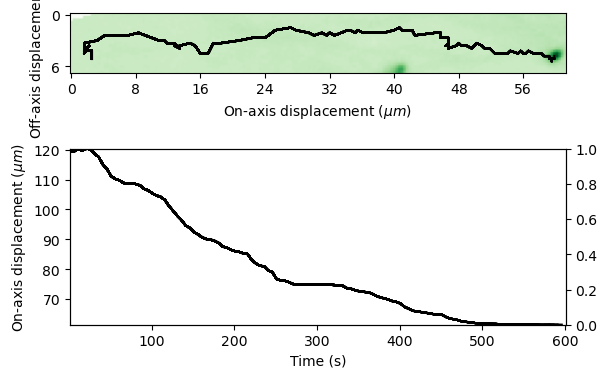

In [14]:
particle_df = traj_df_3[traj_df_3.particle == particle].copy()

distance_to_cen = particle_df[["distance_to_centrosome_%d" % cen]].values

v = particle_df[["v"]].values
timepoints = particle_df[["t"]].values

bead_locs = (particle_df[["x", "y"]].values / dataset.mpp).astype(int)
delta_y = bead_locs[-1, 1] - bead_locs[0, 1]
delta_x = bead_locs[-1, 0] - bead_locs[0, 0]
print(delta_x, delta_y)
angle = np.arctan(delta_y / delta_x)
if delta_x < 0:
    angle += np.pi

margin = 10
xmin, xmax, ymin, ymax = (
    bead_locs[:, 0].min() - margin,
    bead_locs[:, 0].max() + margin,
    bead_locs[:, 1].min() - margin,
    bead_locs[:, 1].max() + margin,
)

bead_locs_rot = (bead_locs - np.array([[xmin, ymin]])) @ np.array(
    [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
)
if delta_x > 0 and delta_y > 0:
    bead_locs_rot[:, 1] += (xmax - xmin) * np.sin(angle)
elif delta_x > 0 and delta_y < 0:
    bead_locs_rot[:, 0] += (ymax - ymin) * np.sin(-angle)
elif delta_x < 0 and delta_y < 0:
    bead_locs_rot[:, 0] += (xmax - xmin) * np.cos(angle - np.pi) + (
        ymax - ymin
    ) * np.sin(angle - np.pi)
    bead_locs_rot[:, 1] += (ymax - ymin) * np.cos(angle - np.pi)
elif delta_x < 0 and delta_y > 0:
    bead_locs_rot[:, 0] += (xmax - xmin) * np.cos(np.pi - angle)
    bead_locs_rot[:, 1] += (xmax - xmin) * np.sin(np.pi - angle) + (
        ymax - ymin
    ) * np.cos(np.pi - angle)
bead_locs_rot = bead_locs_rot.astype(int)
margin_rot = 5
xmin_rot, xmax_rot, ymin_rot, ymax_rot = (
    bead_locs_rot[:, 0].min() - margin_rot,
    bead_locs_rot[:, 0].max() + margin_rot,
    bead_locs_rot[:, 1].min() - margin_rot,
    bead_locs_rot[:, 1].max() + margin_rot,
)

video_name = output_path / ("bead_%d.gif" % particle)
fps = 30

fig, ax = plt.subplots(2, 1)
ax_twin = ax[1].twinx()
plt.subplots_adjust(hspace=0.1)


def make_frame(t):
    i = int(t * fps)
    frame = np.array(dataset.frames[i][ymin:ymax, xmin:xmax])
    frame = rotate(frame, angle=angle / np.pi * 180)
    frame = frame[ymin_rot:ymax_rot, xmin_rot:xmax_rot]
    ax[0].imshow(frame, cmap="Greens")
    ax[0].plot(
        bead_locs_rot[:i, 0] - xmin_rot, bead_locs_rot[:i, 1] - ymin_rot, color="k"
    )
    ax[0].set_xticklabels([int(x * dataset.mpp) for x in ax[0].get_xticks()])
    ax[0].set_yticklabels([int(x * dataset.mpp) for x in ax[0].get_yticks()])
    ax[0].set_xlabel("On-axis displacement ($\mu m$)")
    ax[0].set_ylabel("Off-axis displacement ($\mu m$)")
    ax[1].plot(timepoints[:i], distance_to_cen[:i], color="k")
    ax[1].set_xlim(timepoints[0], timepoints[-1])
    ax[1].set_ylim(distance_to_cen.min(), distance_to_cen.max())
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("On-axis displacement ($\mu m$)")
    return mplfig_to_npimage(fig)


animation = VideoClip(
    make_frame, duration=len(dataset.frames) / fps
)  #  len(dataset.frames))
animation.write_gif(video_name, fps=fps)

## Run length schematic

/home/liboyan/miniconda3/envs/mt/lib/python3.9/site-packages/matplotlib/patches.py:1145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


Saving figure ../figures/220930_1um-beads/run_schematic


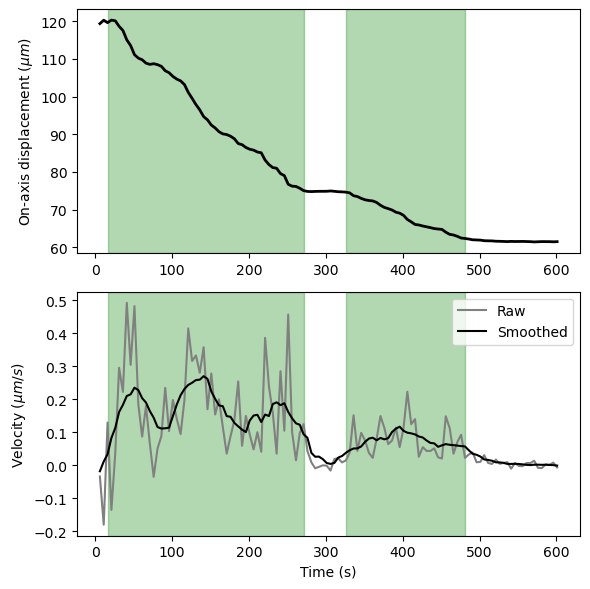

In [15]:
particle_df = traj_df_3[traj_df_3.particle == particle].copy()
distance_to_cen = particle_df[["distance_to_centrosome_%d" % cen]].values

v = particle_df[["v"]].values
timepoints = particle_df[["t"]].values

_, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(timepoints[1:], distance_to_cen[1:], color="k", linewidth=2)
ax[1].plot(timepoints[1:], v[1:], color="gray", label="Raw")
conv_size = 10
v_conv = np.convolve(v[1:].flatten(), np.ones(conv_size), "same") / conv_size
ax[1].plot(timepoints[1:], v_conv, color="k", label="Smoothed")
isrun_arr = (v_conv > 0.04).astype(int)
run_start = np.where((isrun_arr[:-1] == 0) & (isrun_arr[1:] == 1))[0] + 1
run_end = np.where((isrun_arr[:-1] == 1) & (isrun_arr[1:] == 0))[0]
if run_start[0] > run_end[0]:
    run_start = [0] + run_start.tolist()
e_last = 0
s_new = []
e_new = []
for i in range(min(len(run_start), len(run_end))):
    s = run_start[i]
    e = run_end[i]
    if s - e_last <= 2 and s != 0:
        e_new = e_new[:-1]
        e_new.append(e)
    elif e - s <= 2:
        continue
    else:
        s_new.append(run_start[i])
        e_new.append(run_end[i])
    e_last = e
for s, e in zip(s_new, e_new):
    ax[0].axvspan(timepoints[s], timepoints[e], alpha=0.3, color="green")
    ax[1].axvspan(timepoints[s], timepoints[e], alpha=0.3, color="green")
ax[0].set_ylabel("On-axis displacement ($\mu m$)")
ax[1].set_ylabel("Velocity ($\mu m/s$)")
ax[1].set_xlabel("Time (s)")
ax[1].legend()
save_fig(output_path / "run_schematic")

# Statistics

## Net replacement

Saving figure ../figures/220930_1um-beads/Replacement


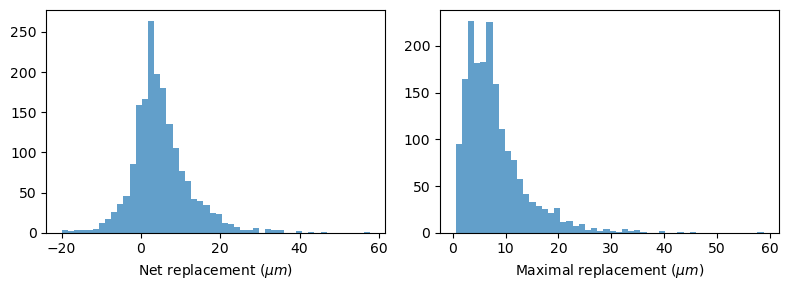

In [16]:
_, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(beads_df.d_net, bins=50, alpha=0.7)
ax[1].hist(beads_df.d_max, bins=50, alpha=0.7)
ax[0].set_xlabel(r"Net replacement ($\mu m$)")
ax[1].set_xlabel(r"Maximal replacement ($\mu m$)")
save_fig(output_path / "Replacement")

## Radial velocity distribution

Saving figure ../figures/220930_1um-beads/v_seg
0.059205702878423604 0.05709833058224007


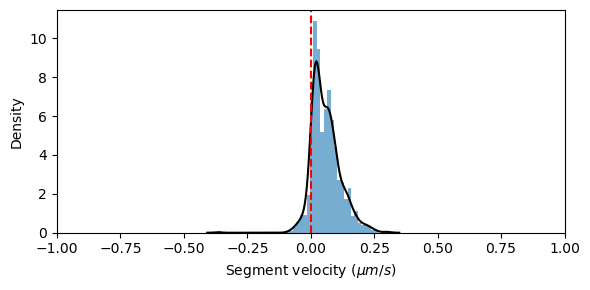

In [17]:
from itertools import chain
_, ax = plt.subplots(1, 1, figsize=(6, 3))
v_seg = list(chain(*(beads_df[beads_df.active].v_seg.tolist())))
sns.histplot(v_seg, bins=50, edgecolor=None, ax=ax, stat="density", alpha=0.6)
sns.kdeplot(v_seg, color="k")
ax.axvline(0, linestyle='--', color="r")
ax.set_xlabel("Segment velocity ($\mu m/s$)")
ax.set_xlim([-1, 1])
save_fig(output_path / "v_seg")
print(np.mean(v_seg), np.std(v_seg))

Saving figure ../figures/220930_1um-beads/v_act
0.10961684380561282


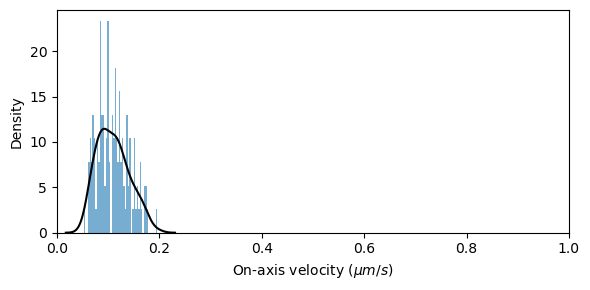

In [18]:
_, ax = plt.subplots(1, 1, figsize=(6, 3))
v = beads_df[beads_df.active].v_act
sns.histplot(v, bins=50, edgecolor=None, ax=ax, stat="density", alpha=0.6)
sns.kdeplot(v, color="k")
ax.set_xlabel("On-axis velocity ($\mu m/s$)")
ax.set_xlim([0, 1])
save_fig(output_path / "v_act")
print(v.mean())

Saving figure ../figures/220930_1um-beads/v_act_max
0.19490300344566927


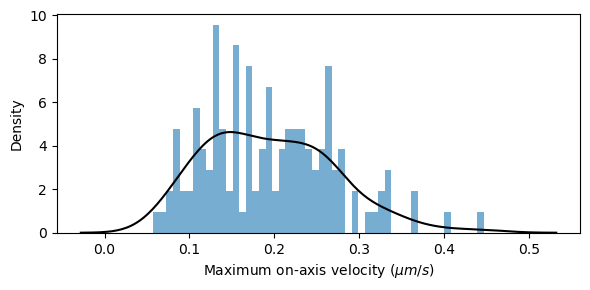

In [19]:
_, ax = plt.subplots(1, 1, figsize=(6, 3))
v = beads_df[beads_df.active].v_act_max
sns.histplot(v, bins=50, ax=ax, edgecolor=None, stat="density", alpha=0.6)
sns.kdeplot(v, color="k")
ax.set_xlabel("Maximum on-axis velocity ($\mu m/s$)")
save_fig(output_path / "v_act_max")
print(v.mean())

## Angular velocity distribution

Saving figure ../figures/220930_1um-beads/AngularVelocity


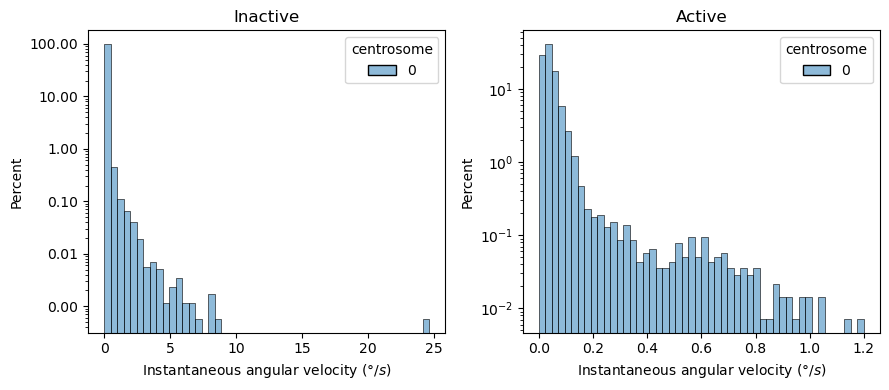

In [20]:
hist_kwargs = dict(color="gray", alpha=0.8, bins=50)

traj_df_2.w = traj_df_2.w + 1e-6
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(
    data=traj_df_2[np.logical_not(traj_df_2.active)],
    x="w",
    hue="centrosome",
    ax=ax[0],
    stat="percent",
    bins=50,
    log_scale=[False, True],
    legend=True,
)
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
sns.histplot(
    data=traj_df_2[traj_df_2.active],
    x="w",
    hue="centrosome",
    ax=ax[1],
    stat="percent",
    bins=50,
    log_scale=[False, True],
    legend=True,
)
# ax[0].set_xlim([0, 13])
# ax[1].set_xlim([0, 2])

for i, a in enumerate(ax):
    a.set_xlabel(r"Instantaneous angular velocity ($\degree/s$)")
    # a.set_yscale("log")
    a.set_title(["Inactive", "Active"][i])
    # a.set_xlim([0, 13])

save_fig(output_path / "AngularVelocity")

Text(0.5, 0, 'Mamimum angular velocity ($\\degree/s$)')

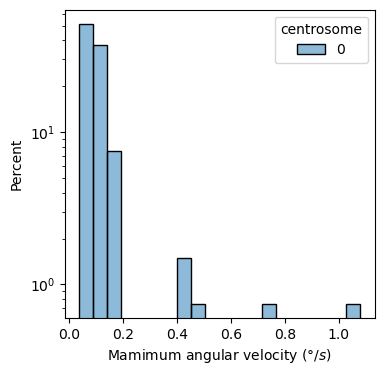

In [21]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.histplot(
    data=beads_df[beads_df.active],
    x="w_max",
    hue="centrosome",
    ax=ax,
    stat="percent",
    bins=20,
    log_scale=[False, True],
    legend=True,
)
ax.set_xlabel("Mamimum angular velocity ($\degree/s$)")

Text(0, 0.5, 'Off-axis velocity ($\\degree / s$)')

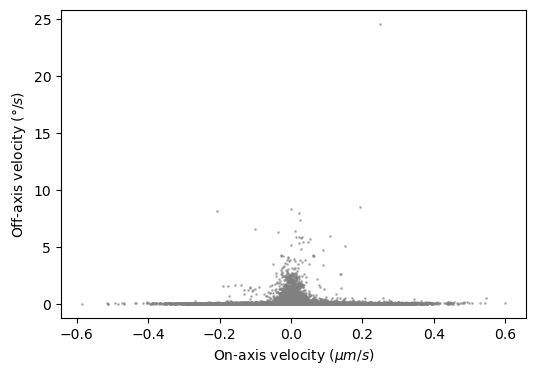

In [22]:
_, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(traj_df_2.v, traj_df_2.w, s=1, color="gray", alpha=0.5)
ax.set_xlabel("On-axis velocity ($\mu m/s$)")
ax.set_ylabel("Off-axis velocity ($\degree / s$)")

## Processivity

### Run length

6.2491221100667
Saving figure ../figures/220930_1um-beads/Runlength


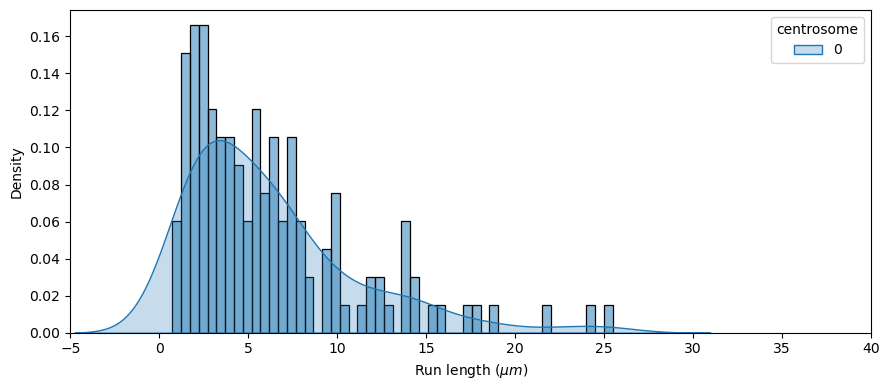

In [23]:
_, ax = plt.subplots(1, 1, figsize=(9, 4))
sns.histplot(
    data=beads_df[beads_df.active],
    x="d_walk_max",
    hue="centrosome",
    ax=ax,
    stat="density",
    bins=50,
    legend=True,
)
sns.kdeplot(
    data=beads_df[beads_df.active],
    x="d_walk_max",
    hue="centrosome",
    ax=ax,
    fill=True,
    legend=True,
)
ax.set_xlabel("Run length ($\mu m$)")
ax.set_xlim([-5, 40])
print(beads_df[beads_df.active].d_walk_max.mean())
save_fig(output_path / "Runlength")

2.576390115267052
Saving figure ../figures/220930_1um-beads/Runlength


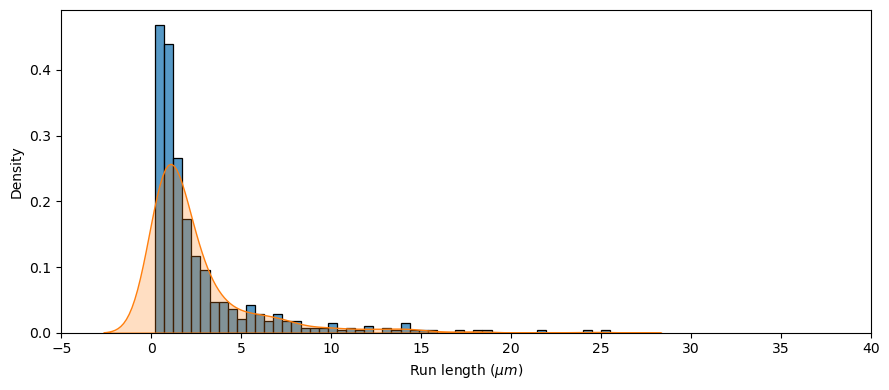

In [24]:
_, ax = plt.subplots(1, 1, figsize=(9, 4))
d_walk = list(chain(*(beads_df[beads_df.active].d_walk.tolist())))
sns.histplot(
    d_walk,
    ax=ax,
    stat="density",
    bins=50,
    legend=True,
)
sns.kdeplot(
    d_walk,
    ax=ax,
    fill=True,
    legend=True,
)
ax.set_xlabel("Run length ($\mu m$)")
ax.set_xlim([-5, 40])
print(np.mean(d_walk))
save_fig(output_path / "Runlength")

### Run time

44.03483322332043
Saving figure ../figures/220930_1um-beads/Runtime


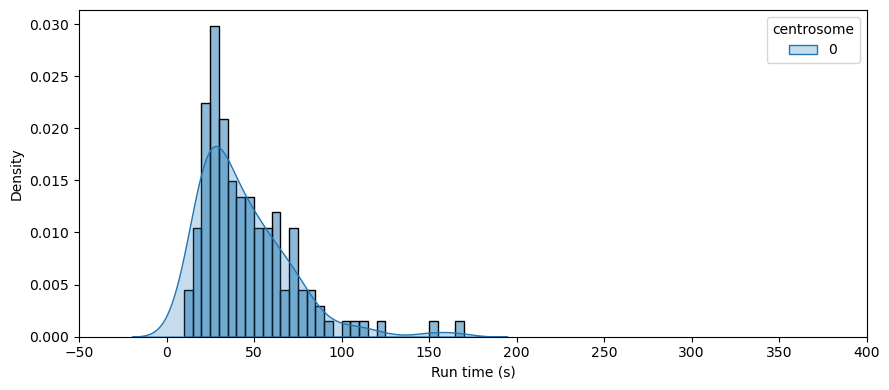

In [25]:
_, ax = plt.subplots(1, 1, figsize=(9, 4))
sns.histplot(
    data=beads_df[beads_df.active],
    x="t_walk_max",
    hue="centrosome",
    ax=ax,
    stat="density",
    binwidth=5,
    legend=True,
)
sns.kdeplot(
    data=beads_df[beads_df.active],
    x="t_walk_max",
    hue="centrosome",
    ax=ax,
    fill=True,
    legend=True,
)
print(beads_df[beads_df.active].t_walk_max.mean())
ax.set_xlabel("Run time (s)")
ax.set_xlim([-50, 400])
save_fig(output_path / "Runtime")

21.430024792965703
Saving figure ../figures/220930_1um-beads/Runlength


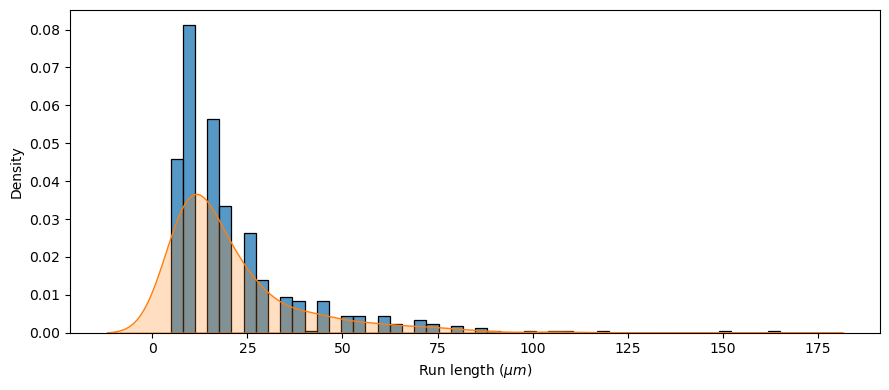

In [26]:
_, ax = plt.subplots(1, 1, figsize=(9, 4))
t_walk = list(chain(*(beads_df[beads_df.active].t_walk.tolist())))
sns.histplot(
    t_walk,
    ax=ax,
    stat="density",
    bins=50,
    legend=True,
)
sns.kdeplot(
    t_walk,
    ax=ax,
    fill=True,
    legend=True,
)
ax.set_xlabel("Run length ($\mu m$)")
# ax.set_xlim([-5, 40])
print(np.mean(t_walk))
save_fig(output_path / "Runlength")

## Time vs distance

  0%|          | 0/134 [00:00<?, ?it/s]

Saving figure ../figures/220930_1um-beads/Time_vs_distance


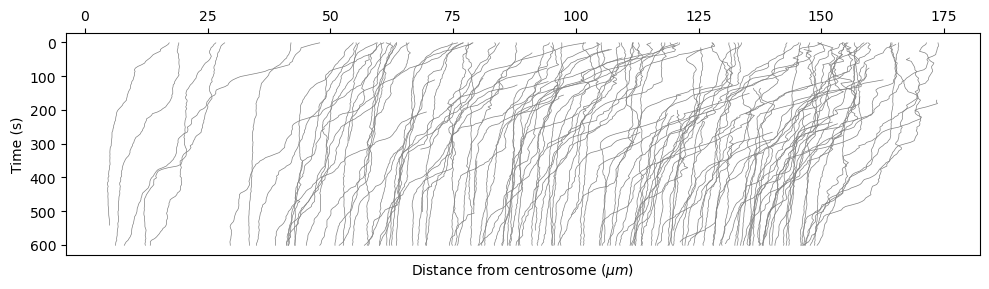

In [27]:
_, ax = plt.subplots(n_mtoc, 1, figsize=(10, 3 * n_mtoc))
if n_mtoc == 1:
    ax = [ax]
for cen in range(n_mtoc):
    for particle in tqdm(
        traj_df_2[(traj_df_2.centrosome == cen) & (traj_df_2.active)].particle.unique()
    ):
        particle_df = traj_df_2[traj_df_2.particle == particle].copy()
        ax[cen].plot(
            particle_df["distance_to_centrosome_%d" % cen],
            particle_df.t,
            lw=0.5,
            alpha=1,
            color="gray",
        )
    ax[cen].invert_yaxis()
    ax[cen].xaxis.tick_top()
    ax[cen].set_ylabel("Time (s)")
    if cen == n_mtoc - 1:
        ax[cen].set_xlabel("Distance from centrosome ($\mu m$)")
save_fig(output_path / "Time_vs_distance")

## Spatiotemporal distribution of v

In [28]:
v_spt_arr = []
for cen in range(n_mtoc):
    traj_df_2["d_bin_%d" % cen] = pd.cut(
        traj_df_2["distance_to_centrosome_%d" % cen], 10
    )
    traj_df_2["d_bin_%d" % cen] = traj_df_2["d_bin_%d" % cen].apply(
        lambda x: int((x.left + x.right) / 2)
    )
    d_bins_map = {
        x: i for i, x in enumerate(np.sort(traj_df_2["d_bin_%d" % cen].values.unique()))
    }

    traj_df_2["d_bin_%d_idx" % cen] = traj_df_2["d_bin_%d" % cen].map(d_bins_map)
    v_space_mat = np.zeros(
        (traj_df_2.frame.nunique() - 1, traj_df_2["d_bin_%d_idx" % cen].nunique())
    )
    for i in tqdm(traj_df_2.frame.unique()):
        if i == 0:
            continue
        for j in traj_df_2.d_bin_0_idx.unique():
            v_space_mat[i - 1, j] = np.nanmean(
                traj_df_2[
                    (traj_df_2.centrosome == cen)
                    & (traj_df_2.active)
                    & (traj_df_2.frame == i)
                    & (traj_df_2["d_bin_%d_idx" % cen] == j)
                ].v
            )
    v_spt_arr.append(v_space_mat)

  0%|          | 0/121 [00:00<?, ?it/s]

/tmp/ipykernel_7762/3922419461.py:21: RuntimeWarning: Mean of empty slice
  v_space_mat[i - 1, j] = np.nanmean(


Saving figure Velocity_heatmap


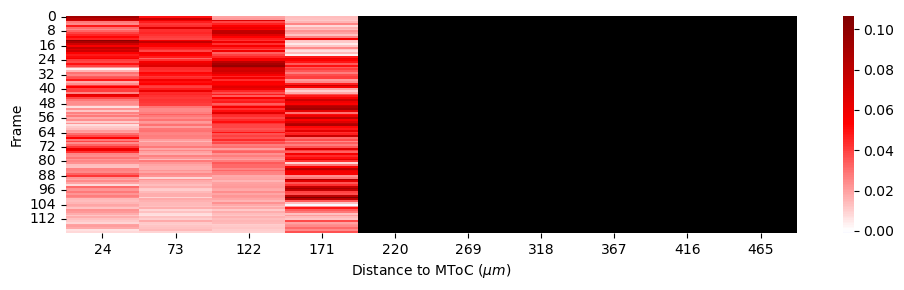

In [29]:
_, ax = plt.subplots(n_mtoc, 1, figsize=(10, 3 * n_mtoc))
if n_mtoc == 1:
    ax = [ax]
for cen in range(n_mtoc):
    hm = sns.heatmap(v_spt_arr[cen], cmap="seismic", center=0, ax=ax[cen])
    hm.set_facecolor("black")
    ax[cen].set_xticklabels(list(d_bins_map.keys()))
    if cen == n_mtoc - 1:
        ax[cen].set_xlabel(r"Distance to MToC ($\mu m$)")
    ax[cen].set_ylabel(r"Frame")
save_fig("Velocity_heatmap")